In [1]:
from common import *
disable_fig_save = False 
save_loc = 'plots'
save_prefix="pathfinding"
config_common(disable_fig_save=disable_fig_save, save_loc=save_loc, save_prefix=save_prefix)
from colors import *

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import re
import warnings

%config InlineBackend.figure_format = 'svg'

from os import path
from typing import Dict, List, Set

import matplotlib.ticker as mtick
import matplotlib as mpl
from scipy.stats.mstats import gmean
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, ScalarFormatter, LogLocator)
import matplotlib.patches as patches
import matplotlib.patches as mpatches
import matplotlib.patheffects as PathEffects
from matplotlib import rc

import seaborn as sns

In [3]:
init_notebook()
figsize = (7,2)
fontsize = 11
Fig.config(fontsize, figsize)

In [4]:
dataf = "../../data/simplekv.csv"

In [5]:
!sha256sum $dataf

b3a1cde90d8af0d7c49ac3bd738bcbdda6cd74fccb662dde5f5c99324a59aab5  ../../data/simplekv.csv


In [6]:
!cat $dataf

pmdk,snashot,msync,msync huge page,msync data journal
3281256264,1977836950,3940719950,3949659868,31139522262
2576875127,1450636566,1661776431,1656284976,3690302674
2464642129,1390314858,1379588503,1364112708,1369009016
4512742749,2548851150,3469773456,3458298891,6976088345
197359502,95220044,435484462,434928038,2642597201
4008052472,2538360068,4530489459,4547056663,33781196838
4017076882,2624750888,6355741644,6280402079,55801690366
pmdk,snashot,msync,msync huge page,msync data journal
3272828869,2008737447,3956363776,3909697316,30987207654
2589101646,1460876069,1692542086,1697434013,3557862863
2487143232,1398845094,1412533072,1416449932,1428220705
4455080376,2594927403,3586059147,3553543614,7030652201
197452783,108540384,434804607,449520288,2632148852
4060895063,2607182104,4496241541,4528737890,33689661935
3984920227,2662111601,6253685968,6342497748,53527551826
snashot-unaligned
1951331806
1473640332
1388756843
2564231975
97774338
2511586382
2881525793


In [7]:
def prefix_list(l, prefix):
    return [prefix + elem for elem in l]

In [8]:
df_raw = pd.read_csv(dataf, index_col=None)
df_raw

,pmdk,snashot,msync,msync huge page,msync data journal
0,3281256264,1977836950,3940719950,3949659868,31139522262
1,2576875127,1450636566,1661776431,1656284976,3690302674
2,2464642129,1390314858,1379588503,1364112708,1369009016
3,4512742749,2548851150,3469773456,3458298891,6976088345
4,197359502,95220044,435484462,434928038,2642597201
5,4008052472,2538360068,4530489459,4547056663,33781196838
6,4017076882,2624750888,6355741644,6280402079,55801690366
7,pmdk,snashot,msync,msync huge page,msync data journal
8,3272828869,2008737447,3956363776,3909697316,30987207654
9,2589101646,1460876069,1692542086,1697434013,3557862863


In [9]:
index_vals =  ['a', 'b', 'c', 'd', 'e', 'f', 'g']
index_nv = prefix_list(index_vals, 'nv_')
index_v = prefix_list(index_vals, 'v_')
index_ua = prefix_list(index_vals, 'ua_')
index_comb = index_v + ['drop'] + index_nv + ['drop'] + index_ua
df_raw.index = index_comb
df_raw = df_raw.T
del df_raw['drop']
df_raw = df_raw.T

In [10]:
v = (df_raw.T[index_v]).T[['pmdk', 'snashot', 'msync', 'msync huge page', 'msync data journal']]
v.index = index_vals
v

,pmdk,snashot,msync,msync huge page,msync data journal
a,3281256264,1977836950,3940719950,3949659868,31139522262
b,2576875127,1450636566,1661776431,1656284976,3690302674
c,2464642129,1390314858,1379588503,1364112708,1369009016
d,4512742749,2548851150,3469773456,3458298891,6976088345
e,197359502,95220044,435484462,434928038,2642597201
f,4008052472,2538360068,4530489459,4547056663,33781196838
g,4017076882,2624750888,6355741644,6280402079,55801690366


In [11]:
nv = (df_raw.T[index_nv]).T['snashot']
nv.index = index_vals
nv

a    2008737447
b    1460876069
c    1398845094
d    2594927403
e     108540384
f    2607182104
g    2662111601
Name: snashot, dtype: object

In [12]:
ua = (df_raw.T[index_ua]).T['pmdk']
ua.index = index_vals
ua

a    1951331806
b    1473640332
c    1388756843
d    2564231975
e      97774338
f    2511586382
g    2881525793
Name: pmdk, dtype: object

In [13]:
df = pd.DataFrame()
df['PMDK'] = np.int_(v['pmdk'])
df['Snapy'] = np.int_(v['snashot'])
df['Snapy-NV'] = np.int_(nv)
df['Snapy + unaligned'] = np.int_(ua)
df['msync (4 KiB)'] = np.int_(v['msync'])
df['msync (2 MiB)'] = np.int_(v['msync huge page'])
df['msync data journal'] = np.int_(v['msync data journal'])
df.index = [val.capitalize() for val in index_vals]
df

,PMDK,Snapy,Snapy-NV,Snapy + unaligned,msync (4 KiB),msync (2 MiB),msync data journal
A,3281256264,1977836950,2008737447,1951331806,3940719950,3949659868,31139522262
B,2576875127,1450636566,1460876069,1473640332,1661776431,1656284976,3690302674
C,2464642129,1390314858,1398845094,1388756843,1379588503,1364112708,1369009016
D,4512742749,2548851150,2594927403,2564231975,3469773456,3458298891,6976088345
E,197359502,95220044,108540384,97774338,435484462,434928038,2642597201
F,4008052472,2538360068,2607182104,2511586382,4530489459,4547056663,33781196838
G,4017076882,2624750888,2662111601,2881525793,6355741644,6280402079,55801690366


In [14]:
pmdk_col = df['PMDK']
df_norm = df.copy(deep=True)
for col in df:
    df_norm[col] = df[col]/pmdk_col
df_norm

,PMDK,Snapy,Snapy-NV,Snapy + unaligned,msync (4 KiB),msync (2 MiB),msync data journal
A,1.0,0.602768,0.612185,0.594690,1.200979,1.203704,9.490122
B,1.0,0.562944,0.566918,0.571871,0.644880,0.642749,1.432084
C,1.0,0.564104,0.567565,0.563472,0.559752,0.553473,0.555460
D,1.0,0.564812,0.575022,0.568220,0.768884,0.766341,1.545864
E,1.0,0.482470,0.549963,0.495412,2.206554,2.203735,13.389764
F,1.0,0.633315,0.650486,0.626635,1.130347,1.134480,8.428332
G,1.0,0.653398,0.662699,0.717319,1.582181,1.563426,13.891118


In [15]:
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
# rc('text', usetex=True)

In [16]:
new_labels = r"""\textbf{Workloads:}
\textbf{A)} R: 50, W: 50    \textbf{B)} R: 95, W: 5    \textbf{C)} R: 100 \textbf{D)} Read latest \textbf{E)} Read-modify-write
\textbf{G)} Short range scan \textbf{D)} W: 100"""


<ipython-input-20-0e5dd2c48615>:40: MatplotlibDeprecationWarning: hatch must consist of a string of "*+-./OX\ox|" or None, but found the following invalid values " ". Passing invalid values is deprecated since 3.4 and will become an error two minor releases later.
  bar.set_hatch(hatch)


Plot saved as `plots/pathfinding/simplekv.png`

Plot saved as `plots/pathfinding/simplekv.png`

Using pdfcrop on `plots/pathfinding/simplekv.png` with command `pdfcrop plots/pathfinding/simplekv.pdf plots/pathfinding/simplekv.pdf`

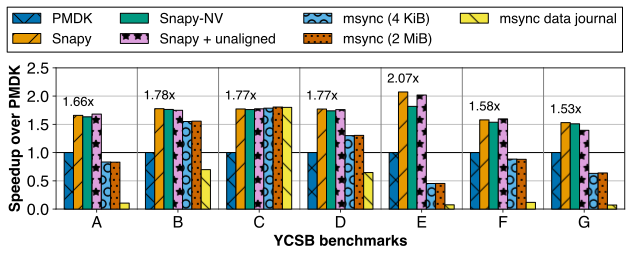

In [20]:
Fig.config(16, (10.2, 2.6))
speedup = 1/df_norm

colors = [
 (0.0, 0.45, 0.7, 1.0),
 (0.9, 0.6, 0.0, 1.0),
 (0.0, 0.6, 0.5, 1.0),
 'plum',
 (0.35, 0.7, 0.9, 1.0),
 (0.8, 0.4, 0.0, 1.0),
 (0.95, 0.9, 0.25, 1.0),
]

ax = speedup.plot.bar(**Fig.get_kwargs(width=0.8), color=colors)
f = Fig(ax)
ax.set_ylim((0, 2.4))

# f.fmt_label('YCSB benchmarks', 'Relative performance')
f.fmt_label('YCSB benchmarks', 'Speedup over PMDK', fontsize=15)
f.add_bar_labels(
    [False, True, False, False, False, False, False], 
    precision=2, fontsize=fontsize+2, over_fig=False, alpha=0)
f.xrot(rot=0)
f.fmt_grid(axis='y')
ax.set_yticks(np.arange(0, 2.51, 0.5))
ax.axline((0, 1), (10, 1), zorder=2, color='black', linewidth=1)

for i in range(0, 7):
    ax.axline((i + 0.5, 1), (i + 0.5, 2), zorder=2, color='gray', linewidth=1)

ax.set_xlim(-0.5, 6.5)
    
bars = ax.patches
hatches = ''.join(h*len(speedup) for h in ['x', '/',  ' ', '*', '', 'O', '.', '\\'])


for bar, hatch in zip(bars, hatches):
    if hatch == '.':
        hatch = '..'
    bar.set_hatch(hatch)

f.fmt_legend(fontsize=14, y_off_scale=1.02, x_off_scale=0.91, ncol=4)
    
save_fig('simplekv')

### Extended abstract

Plot saved as `plots/pathfinding/simplekv_ea.png`

Plot saved as `plots/pathfinding/simplekv_ea.png`

Using pdfcrop on `plots/pathfinding/simplekv_ea.png` with command `pdfcrop plots/pathfinding/simplekv_ea.pdf plots/pathfinding/simplekv_ea.pdf`

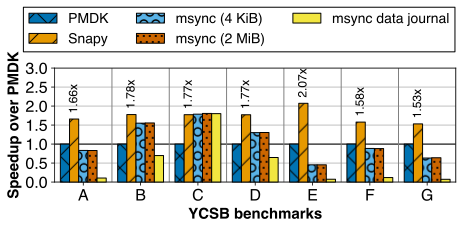

In [18]:
Fig.config(16, (7.2, 2.1))
df_ea = df_norm[['PMDK', 'Snapy', 'msync (4 KiB)', 'msync (2 MiB)', 'msync data journal']]

speedup_ea = 1/df_ea

colors = [
 (0.0, 0.45, 0.7, 1.0),
 (0.9, 0.6, 0.0, 1.0),
 (0.0, 0.6, 0.5, 1.0),
 'plum',
 (0.35, 0.7, 0.9, 1.0),
 (0.8, 0.4, 0.0, 1.0),
 (0.95, 0.9, 0.25, 1.0),
]

ax = speedup_ea.plot.bar(**Fig.get_kwargs(width=0.8)) #, color=colors)
f = Fig(ax)
ax.set_ylim((0, 3))

# f.fmt_label('YCSB benchmarks', 'Relative performance')
f.fmt_label('YCSB benchmarks', 'Speedup over PMDK', fontsize=15)
f.add_bar_labels(
    [False, True, False, False, False], 
    precision=2, fontsize=fontsize+1, over_fig=False, alpha=0, rotation=90)
f.xrot(rot=0)
f.fmt_grid(axis='y')
ax.set_yticks(np.arange(0, 3.1, 0.5))
ax.axline((0, 1), (10, 1), zorder=2, color='black', linewidth=1)

for i in range(0, 7):
    ax.axline((i + 0.5, 1), (i + 0.5, 2), zorder=2, color='gray', linewidth=1)

ax.set_xlim(-0.5, 6.5)
    
bars = ax.patches
hatches = ''.join(h*len(speedup) for h in ['x', '/',  ' ', '*', '', 'O', '.', '\\'])


hatches = ''.join(h*len(df_norm) for h in 'x/O.')

for bar, hatch in zip(bars, hatches):
    if hatch == '.':
        hatch = '..'
    bar.set_hatch(hatch)


f.fmt_legend(fontsize=14, y_off_scale=1.1, x_off_scale=0.92, ncol=3)
    
save_fig('simplekv_ea')